# Жүктеу және алдын-ала өңдеу

Dataset орналасқан жері
https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af

In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [30]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpeg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

size_image = 80

lung_aca_train = np.array(Dataset_loader('data/train/lung_aca',size_image))
lung_scc_train = np.array(Dataset_loader('data/train/lung_scc',size_image))
lung_n_train = np.array(Dataset_loader('data/train/lung_n',size_image))

lung_aca_test = np.array(Dataset_loader('data/val/lung_aca',size_image))
lung_scc_test = np.array(Dataset_loader('data/val/lung_scc',size_image))
lung_n_test = np.array(Dataset_loader('data/val/lung_n',size_image))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.21it/s]


In [31]:
# Тері қатерлі ісігі: қатерлі және жақсы
# Белгілерді жасау
lung_aca_train_label = np.ones(len(lung_aca_train))+1
lung_scc_train_label = np.ones(len(lung_scc_train))
lung_n_train_label = np.zeros(len(lung_n_train))

lung_aca_test_label = np.ones(len(lung_aca_test))+1
lung_scc_test_label = np.ones(len(lung_scc_test))
lung_n_test_label = np.zeros(len(lung_n_test))

# Деректерді біріктіру
X_train = np.concatenate((lung_aca_train, lung_scc_train, lung_n_train), axis = 0)
Y_train = np.concatenate((lung_aca_train_label, lung_scc_train_label, lung_n_train_label), axis = 0)

X_test = np.concatenate((lung_aca_test, lung_scc_test, lung_n_test), axis = 0)
Y_test = np.concatenate((lung_aca_test_label, lung_scc_test_label, lung_n_test_label), axis = 0)

# Оқыту деректерін араластыру
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Тест деректерін араластыру
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# Категориялық
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

In [32]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

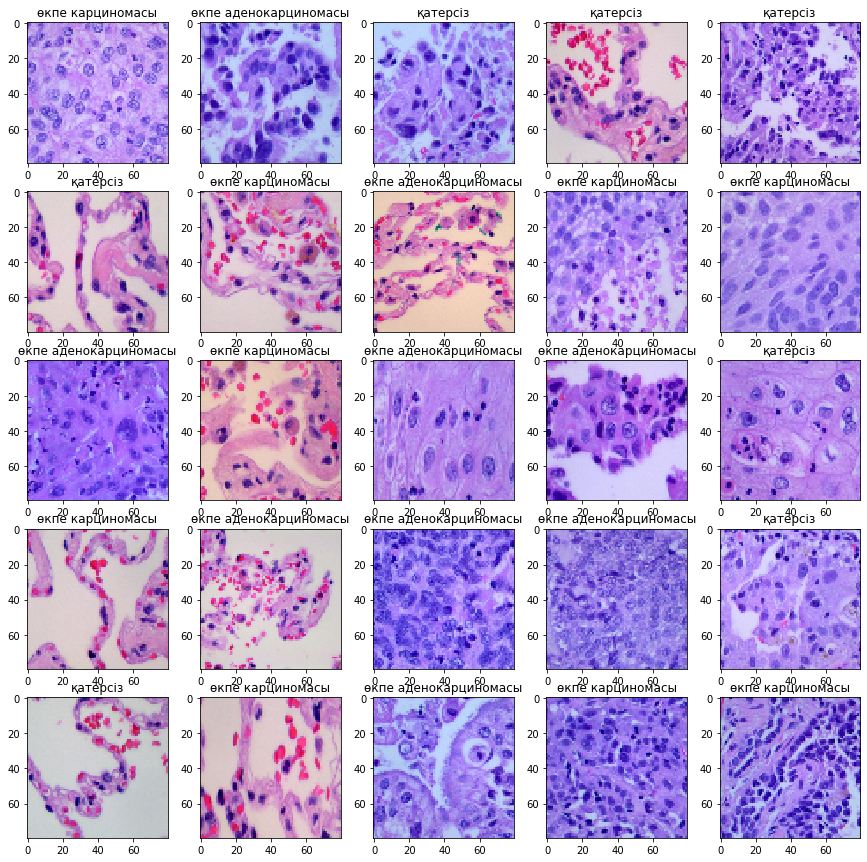

In [67]:
## Мольдердің алғашқы 15 суретін көрсету және олардың жіктелуі
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('қатерсіз')
    elif np.argmax(Y_train[i]) == 1:
        ax.title.set_text('өкпе карциномасы')
    else:
        ax.title.set_text('өкпе аденокарциномасы')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [34]:
BATCH_SIZE = 16

# Бастапқы генераторды пайдалану
train_generator = ImageDataGenerator(
        zoom_range=2,  # кездейсоқ масштабтау үшін ауқымды орнату
        rotation_range = 90,
        horizontal_flip=True,  # суреттерді кездейсоқ бұру
        vertical_flip=True,  # суреттерді кездейсоқ бұру
    )

In [43]:
K.clear_session()
gc.collect()

net = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(size_image,size_image,3)
)

model = Sequential()
model.add(net)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(3, activation='softmax'))


model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 2, 2, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 3,236,035
Trainable params: 3,212,099
Non-trainable params: 23,936
_________________________________________________________________


In [44]:
# Оқу Жылдамдығын Төмендету
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Бақылау нүктесі
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [45]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/10
150/150 [==============================] - 40s 265ms/step - loss: 0.5652 - accuracy: 0.5938 - val_loss: 0.4629 - val_accuracy: 0.7000
Epoch 2/10
150/150 [==============================] - 44s 295ms/step - loss: 0.3937 - accuracy: 0.7417 - val_loss: 0.1732 - val_accuracy: 0.8967
Epoch 3/10
150/150 [==============================] - 42s 279ms/step - loss: 0.3216 - accuracy: 0.7921 - val_loss: 0.1299 - val_accuracy: 0.9250
Epoch 4/10
150/150 [==============================] - 40s 264ms/step - loss: 0.3210 - accuracy: 0.8021 - val_loss: 0.1740 - val_accuracy: 0.8900
Epoch 5/10
150/150 [==============================] - 41s 276ms/step - loss: 0.2866 - accuracy: 0.8321 - val_loss: 0.1389 - val_accuracy: 0.9200
Epoch 6/10
150/150 [==============================] - 40s 264ms/step - loss: 0.2774 - accuracy: 0.8267 - val_loss: 0.1130 - val_accuracy: 0.9300
Epoch 7/10
150/150 [==============================] - 41s 276ms/step - loss: 0.2850 - accuracy: 0.8325 - val_loss: 0.1068 - val_ac

In [46]:
model.save_weights(filepath)

In [47]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

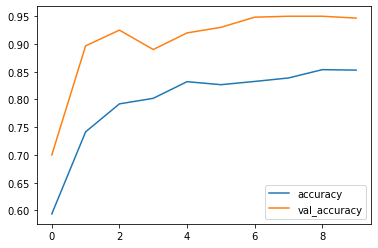

In [48]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

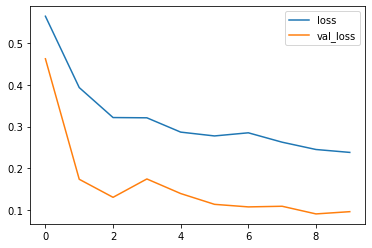

In [49]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Результат Көрсету

In [50]:
model.load_weights("weights.best.hdf5")

In [51]:
Y_val_pred = model.predict(x_val)

In [52]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9466666666666667

In [53]:
Y_pred = model.predict(X_test)

In [54]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.predict, which supports generators.


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.58s/it]


### Шатастыру матрицасы арқылу мәндерді көру

Шатастыру матрицасы, нормаланусыз келтірусіз
[[981   0  19]
 [  0 920  80]
 [  0  36 964]]


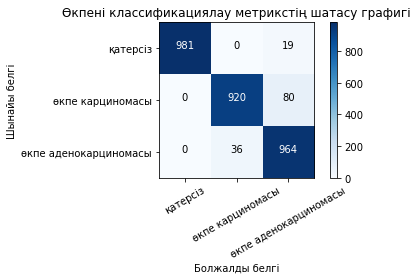

In [71]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Бұл функция шатасу матрицасын басып шығарады және жасайды.
    Нормализацияны 'normalize=True' орнату арқылы қолдануға болады.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Нормаланған шатастыру матрицасы")
    else:
        print('Шатастыру матрицасы, нормаланусыз келтірусіз')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Шынайы белгі')
    plt.xlabel('Болжалды белгі')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label = ['қатерсіз', 'өкпе карциномасы', 'өкпе аденокарциномасы']
plot_confusion_matrix(cm, cm_plot_label, title ='Өкпені классификациялау метрикстің шатасу графигі')

In [63]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1000
           1       0.92      0.95      0.94      1000
           2       0.94      0.92      0.93      1000

   micro avg       0.95      0.95      0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



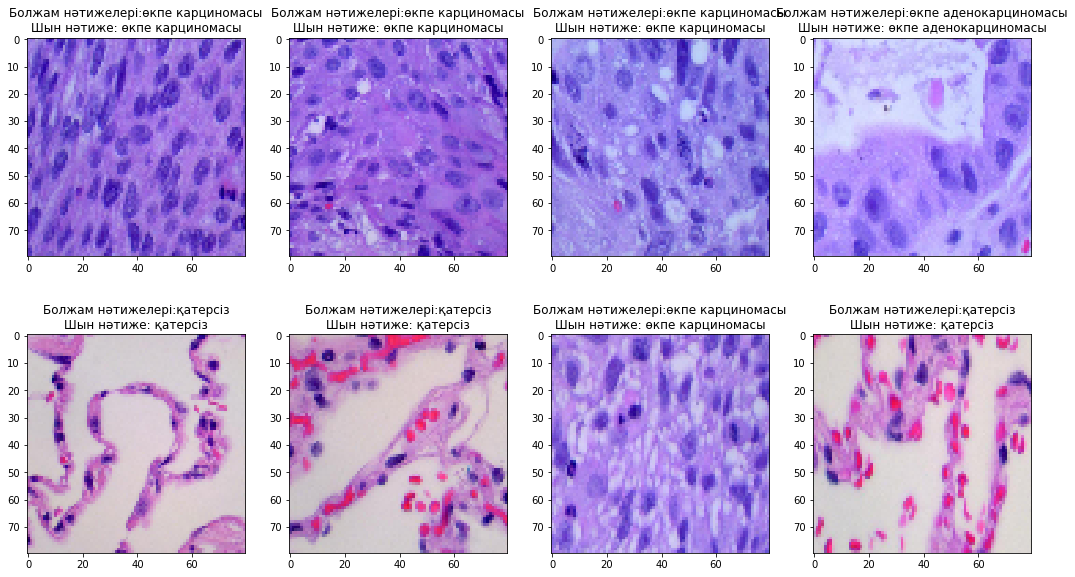

In [70]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Алғашқы 8 суретті көрсету
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "қатерсіз"
    elif namecode==1:
        return "өкпе карциномасы"
    else:
        return "өкпе аденокарциномасы"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Болжам нәтижелері:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Шын нәтиже: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()